In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# A basic example of reduced order quadrature

In [Antil _et al_ (2013)](https://arxiv.org/abs/1210.0577) the concept of _reduced order quadrature_ (ROQ) was introduced. The method has, in particular, found extensive use in the field of gravitational wave astronomy, following the initial work of [Canizares _et al_, 2013](https://ui.adsabs.harvard.edu/abs/2013PhRvD..87l4005C/abstract), where it is used to **massively speed-up the computation of likelihoods** during stochastic sampling (via, e.g., [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) or [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm)). In this note I will attempt to provide a brief, simple example of the "quadrature" part of this method and its use. I will not go into detail about the slightly more complex world of creating a "[reduced order model](https://en.wikipedia.org/wiki/Model_order_reduction)".

## What's a "quadrature"?

Within reduced order quadrature, the "[quadrature](https://en.wikipedia.org/wiki/Quadrature_(mathematics))" term is just another way of saying numerical integration, i.e., calculating an integral by approximating it as a sum. E.g.,: 

$$
\int_a^b f(x) {\rm d}x \approx \sum_{i=1}^N f(x_i) \Delta x,
$$

where $f(x)$ is the integrand (the function to be integrated) integrated between the limits $a$ and $b$, $N$ is the number of intervals over which to split the sum and therefore $x_1 = a$ and $\Delta x = (b - a) / N$. More accurate numerical approximations such as the [trapezium rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) can be used.

In the papers above, and what we will assume in this example, is that the integrand is a very specific function: the natural logarithm of a [Gaussian likelihood](https://en.wikipedia.org/wiki/Normal_distribution) function:

$$
\ln{L(\vec{\theta})} = -\int_{-\infty}^{\infty} \frac{\left(d(t) - m(t;\vec{\theta})\right)^2}{2\sigma(t)^2} {\rm d}t,
$$

where $d(t)$ is some data as a function of $t$ (which might be, for example, _time_), $m(t;\vec{\theta})$ is a predictive model of some process as a function of $t$ and a set of parameters $\vec{\theta}$, and $\sigma(t)$ is an estimate of the noise standard deviation of the data as a function of $t$. In many statistical application, this is the form of the likelihood function you might want to use to, e.g., maximise and find the "best fit" model parameters $\vec{\theta}$, or sample from during the process of approximating a posterior probability distribution on the model parameters.

In realistic applications, the data $d$ is discrete rather than continuous, so the integral naturally becomes a sum with finite bounds (e.g., the start and end times of the data, or a lower and upper frequency range):

$$
\ln{L(\vec{\theta})} \propto \sum_{i=1}^{N} \frac{\left(d(t_i) - m(t_i;\vec{\theta})\right)^2}{\sigma(t_i)^2},
$$

where $N$ is the number of data points.

Reduced order quadrature is a way of speeding up the calculation of this sum by reducing the number point to sum over from $N$ to $M$, where $M \ll N$. This is particularly useful if the model $m$ is computationally expensive, i.e., it takes a long time to evaluate it for large numbers of data points, and/or $N$ is intrinsically large.

To get started on this path I will expand and separate out the terms in the above equation:

\begin{equation}
\ln{L(\vec{\theta})} \propto \left(\sum_{i=1}^{N} \frac{d_i^2}{\sigma_i^2}\right) + \left(\sum_{i=1}^{N} \frac{m_i(\vec{\theta})^2}{\sigma_i^2}\right) - \left(2 \sum_{i=1}^{N} \frac{d_i m_i(\vec{\theta})}{\sigma_i^2}\right),\
\label{eq:expanded}
\tag{1}
\end{equation}

where for compactness I've switched $m(t_i;\vec{\theta})$ to $m_i(\vec{\theta})$. In the subsequent equations I will switch $d_i/\sigma_i \rightarrow d_i$ and $m_i / \sigma_i \rightarrow m_i$, i.e., the data and model terms will be assumed to be already weighted by the noise.

The first term on the right hand side of the Equation $\eqref{eq:expanded}$ does not depend on the parameters $\vec{\theta}$, so no matter what $\vec{\theta}$ is used for the likelihood function it will always be the same. Therefore, $\mathcal{K} = \sum_{i=1}^N d_i^2$ only needs to be calculated once. The other terms must be calculated each time $\vec{\theta}$ changes. In some cases, e.g., that described in [Canizares _et al_, 2013](https://ui.adsabs.harvard.edu/abs/2013PhRvD..87l4005C/abstract), the second term involving the square of the model is analytic and therefore quick to calculate, but I'll not assume this here.


## How do you reduce the number of points?

Reducing the number of points over which you can sum relies on the model $m$ being reducible into a linear superposition of a relatively small number (compared to $N$) of (scaled) basis vectors. This is known as [reduced order modelling](https://en.wikipedia.org/wiki/Model_order_reduction). Most generally the set of basic vectors must be "learned" by training in some way using models evaluated over the full prior range of the parameter space $\vec{\theta}$. After training, there should be a set of basic vectors $b$ such that:

\begin{equation}
m(t; \vec{\theta}) \approx \sum_{j=1}^M C_j(\vec{\theta}) b_j(t)
\label{eq:basis}
\tag{2}
\end{equation}

where it is the coefficients $C$ that depend on the parameters $\vec{\theta}$, but not the basic vectors. Note that often the basis vectors are normalised such that

$$
\sum_{i=1}^N b_{ji} = 1.
$$

If we return to the third term in Equation $\eqref{eq:expanded}$ and substitute in Equation $\eqref{eq:basis}$ we get:

\begin{equation}
\sum_{i=1}^N d_i m_i(\vec{\theta}) \approx \sum_{i=1}^N d_i \left(  \sum_{j=1}^M C_j(\vec{\theta}) b_{ji} \right) \equiv \sum_{j=1}^M C_j(\vec{\theta}) \left(\sum_{i=1}^N d_i  b_{ji}\right),
\label{eq:rhs3}
\tag{3}
\end{equation}

where $b_{ji} = b_j(t_i)$.

> Note: we can see that the rearrangement of the summation terms works by expanding things for $N = M = 2$:
> $d_1 \left(C_1b_{11} + C_2b_{21}\right) + d_2\left(C_1b_{12} + C_2b_{22}\right) \equiv C_1\left(d_1b_{11} + d_2b_{12}\right) + C_2\left(d_1b_{21} + d_2b_{22} \right)$.

Neither the basis vectors $b$ nor the data depend on the parameters $\vec{\theta}$, so the sums over $N$ for each basis vector

$$
D_j = \sum_{i=1}^N d_i b_{ji}
$$

can all be pre-calculated. This means that Equation $\eqref{eq:rhs3}$ becomes a sum over $M$:

$$
\sum_{i=1}^N d_i m_i(\vec{\theta}) \approx \sum_{j=1}^M C_j(\vec{\theta}) D_j.
$$

Something similar can be done for the second term in Equation $\eqref{eq:expanded}$. However, we need a different set of basis vectors that have been calculated from the squared model, such that:

$$
m(t; \vec{\theta})^2 \approx \sum_{j=1}^{M'} C'_j(\vec{\theta}) b'_j(t),
$$

where $M'$ may be different from $M$.

So, in this case we have:

$$
\sum_{i=1}^N m_i(\vec{\theta})^2 \approx \sum_{i=1}^N \sum_{j=1}^{M'} C'_j(\vec{\theta}) b'_{ji} \equiv \sum_{j=1}^{M'} C'_j(\vec{\theta}) \sum_{i=1}^N b'_{ji}.
$$

Again, the sum over $N$ for the basis vectors does not involve $\vec{\theta}$, so these can be pre-computed:

$$
B_j = \sum_{i=1}^N {b'}_{ji}^2,
$$

and we get another sum just over $M'$:

$$
\sum_{i=1}^N m_i(\vec{\theta})^2 \approx \sum_{j=1}^{M'} C'_j(\vec{\theta}) B_j.
$$

Finally, Equation $\eqref{eq:expanded}$ can become:

\begin{equation}
\ln{L(\vec{\theta})} \propto \mathcal{K} + \sum_{j=1}^{M'} C'_j(\vec{\theta}) B_j - 2\sum_{j=1}^M C_j(\vec{\theta}) D_j.
\label{eq:roqlike}
\tag{4}
\end{equation}

So, provided $M \ll N$ and $M' \ll N$, there should be an approximately $N/\text{max}(M, M')$ speed-up in calculating Equation $\eqref{eq:roqlike}$ compared to $\eqref{eq:expanded}$.

## How do you calculate the $C$ coefficients?

To calculate the $C$ coefficients required for Equation $\eqref{eq:roqlike}$ you need to apply a bit of linear algebra. For a particular set of parameters $\vec{\theta}_k$ you need to evaluate the model $m(\vec{\theta}_k)$ at $M$ points (optimally chosing which points is beyond the scope of this note). Say we had only 2 basis vectors, i.e., $M=2$, then we can define the two simultaneous equations:

$$
\begin{eqnarray}
m(t_l;\vec{\theta}_k) & = & \sum_{j=1}^2 C_j(\vec{\theta}_k) b_{jl} \equiv C_1(\vec{\theta}_k) b_{1l} + C_2(\vec{\theta}_k) b_{2l}, \\
m(t_n;\vec{\theta}_k) & = & \sum_{j=1}^2 C_j(\vec{\theta}_k) b_{jn} \equiv C_1(\vec{\theta}_k) b_{1n} + C_2(\vec{\theta}_k) b_{2n},
\end{eqnarray}
$$

which in matrix notation becomes:

$$
\left( \begin{array}{c} m_l(\vec{\theta}_k) \\ m_n(\vec{\theta}_k) \end{array} \right) = \left( \begin{array}{c} C_1(\vec{\theta}_k) \\ C_2(\vec{\theta}_k) \end{array} \right) \left( \begin{array}{cc} b_{1l} & b_{2l} \\ b_{1n} & b_{2n} \end{array} \right) 
$$

where the values of $m_l(\vec{\theta}_k)$ and $m_n(\vec{\theta}_k)$ can be explicitly calculated from the model at the points $t_l$ and $t_n$. The basis vector matrix:

$$
\mathsf{B} = \left( \begin{array}{cc} b_{1l} & b_{2l} \\ b_{1n} & b_{2n} \end{array} \right),
$$

can then be inverted to solve the equations for $C_1(\vec{\theta}_k)$ and $C_2(\vec{\theta}_k)$:

$$
\left( \begin{array}{c} C_1(\vec{\theta}_k) \\ C_2(\vec{\theta}_k) \end{array} \right) = \left( \begin{array}{c} m_l(\vec{\theta}_k) \\ m_n(\vec{\theta}_k) \end{array} \right) \cdot  \mathsf{B}^{-1},
$$

where:

$$
\mathsf{B}^{-1} = \frac{1}{|\mathsf{B}|} \left( \begin{array}{cc} b_{2n} & -b_{2l} \\ -b_{1n} & b_{1l} \end{array} \right),
$$

and the determinant $|B| = b_{1l}b_{2n} - b_{1n}b_{2l}$. So, for this two-basis-vector case we would have:

$$
\begin{eqnarray}
C_1(\vec{\theta}_k) & = \frac{m_l(\vec{\theta}_k) b_{2n} - m_n(\vec{\theta}_k) b_{2l}}{b_{1l}b_{2n} - b_{1n}b_{2l}} \\
C_2(\vec{\theta}_k) & = \frac{-m_l(\vec{\theta}_k) b_{1n} + m_n(\vec{\theta}_k) b_{1l}}{b_{1l}b_{2n} - b_{1n}b_{2l}}.
\end{eqnarray}
$$

The same thing can be done for calculating the $C'$ coefficients, instead using the square of the model and the $b'$ basic vectors.

# A simple example

Here I will provide a simple example where the model is explicitly defined in a way that I already know the basis functions. As stated above, more generally you would need to determine the basis vectors through a process such as reduced order modelling.

The simple example is explicitly defined to be the sum of two simple functions:

$$
f(t; A, \phi_0, m, c) = g(t; A, \phi_0) + h(t; m, c),
$$

where I will set $g(t)$ to be the sine function with a fixed angular frequency but unknown amplitude $A$ and initial phase \phi_0:

$$
g(t; A, \phi_0) = A sin(2.3 t + \phi_0),
$$

and $h(t)$ to be the function for a straight line with an unknown gradient $m$ and $y$-intercept $c$:

$$
h(t; m, c) = m t + c.
$$

These equations can be broken down into four simple basis functions:

$$
\begin{eqnarray}
b_1(t) &= \sin{(2.3 t)}, \\
b_2(t) &= \cos{(2.3 t)}, \\
b_3(t) &= t, \\
b_4(t) &= 1,
\end{eqnarray}
$$

such that:

$$
f(t; A, \phi_0, m, c) = C_1 b_1 + C_2 b_2 + C_3 b_3 + C_4 b_4.
$$

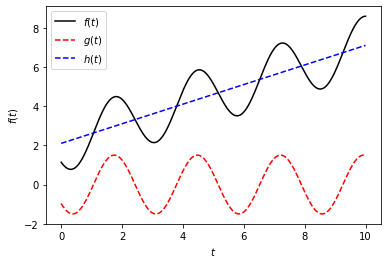

In [95]:
def g(t, A, phi0):
    return A * np.sin(2.3 * t + phi0)

def h(t, m, c):
    return m * t + c

def f(t, A, phi0, m, c):
    return g(t, A, phi0) + h(t, m, c)

# plot an example of the function
A = -1.5
phi0 = 0.7
m = 0.5
c = 2.1

N = 1000  # number of points to evaluate the function
t = np.linspace(0, 10, N)

fig, ax = plt.subplots()
ax.plot(t, f(t, A, phi0, m, c), "k-", label="$f(t)$")
ax.plot(t, g(t, A, phi0), "r--", label="$g(t)$")
ax.plot(t, h(t, m, c), "b--", label="$h(t)$")
ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$f(t)$");

For a particular set of parameters $\vec{\theta}_k = \{A_k, {\phi_0}_{k}, m_k, c_k\}$ the coefficients $C$ can be calculated by evaluating the basic vectors at four points. I will just chose four points evenly spaced in $t$, assuming there are $N$ points in $t$, so $t'_1 = t_1$, $t'_2 = t_{N/4}$, $t'_3 = t_{N/2}$ and $t'_4 = t_{3N/4}$, and solving:

$$
\left(\begin{array}{c} C_1 \\ C_2 \\ C_3 \\ C_4 \end{array}\right) =  \left(\begin{array}{c} f(t_1; A_k, {\phi_0}_k, m_k, c_k) \\ f(t_2; A_k, {\phi_0}_k, m_k, c_k) \\ f(t_3; A_k, {\phi_0}_k, m_k, c_k) \\ f(t_4; A_k, {\phi_0}_k, m_k, c_k)\end{array}\right) \cdot \mathsf{B}^{-1},
$$

where

$$
\mathsf{B} = \left(\begin{array}{cccc} b_1(t_1) & b_1(t_2) & b_1(t_3) & b_1(t_4) \\  b_2(t_1) & b_2(t_2) & b_2(t_3) & b_2(t_4) \\  b_3(t_1) & b_3(t_2) & b_3(t_3) & b_3(t_4) \\  b_4(t_1) & b_4(t_2) & b_4(t_3) & b_4(t_4) \end{array}\right).
$$

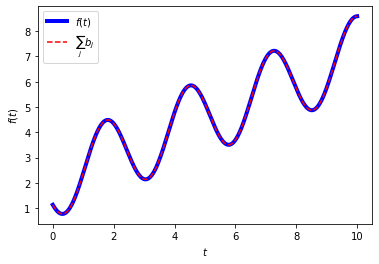

In [3]:
# define the basis vectors
def b1(t):
    return np.sin(2.3 * t)

def b2(t):
    return np.cos(2.3 * t)

def b3(t):
    return t

def b4(t):
    return np.ones_like(t)

# get array of basis vectors over t
Bfull = [b(t) for b in [b1, b2, b3, b4]]

# get indices for 4 tprime values
indices = slice(0, -1, int(N/4) + 1)

# get the B matrix
B = np.array([row[indices] for row in Bfull])

# evaluate f at tprime values
F = f(t[indices], A, phi0, m, c)

# solve for C
C = np.dot(F, np.linalg.inv(B))
#C = np.einsum("i,ij->j", F, np.linalg.inv(B))

# plot original function versus sum of basis vectors
fig, ax = plt.subplots()
ax.plot(t, f(t, A, phi0, m, c), "b-", label="$f(t)$", lw=4)
ax.plot(t, np.sum([C[i] * Bfull[i] for i in range(4)], axis=0), "r--", label="$\sum_j b_j$")
ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$f(t)$");

In the above plot it can be seen that the original function can be reconstructed from the basis vectors.

But, now I'll look at evaluating the natural logarithm for the Gaussian likelihood function, and in particular check out the speed-up using the basis vectors for a range of lengths of data $N$. I'll create some fake data consisting of the function $f$ plus some Gaussian noise of known standard deviation and evaluate the likelihood using the standard function and the reduced order quadrature version.

In this case the integral of the model-squared term is analytic (see [Appendix](#Appendix)):

$$
\int_{t_1}^{t_N} \left(A\sin{(2.3 t + \phi_0)} + mt + c\right)^2 {\rm d}t = \left[\frac{12 A m \sin{\left(\omega t + \phi_{0} \right)} - 3 A \omega \left(A \sin{\left(\omega t + \phi_{0} \right)} + 4 c + 4 m t\right) \cos{\left(\omega t + \phi_{0} \right)} + \omega^{2} t \left(3 A^{2} + 6 c^{2} + 6 c m t + 2 m^{2} t^{2}\right)}{6 \omega^{2}} \right]_{t_1}^{t_N}
$$

where $\omega = 2.3$. I will use this for checking.

If that analytic equation is not present, the model-squared term will need its own set of basis functions. Again, generally these could be calculated with reduced order modelling. But here we will defined the nine basis functions:

$$
\begin{eqnarray}
b'_1(t) &=& \sin{}^2(2.3t), \\
b'_2(t) &=& \cos{}^2(2.3t), \\
b'_3(t) &=& \sin{(2 \times 2.3 t)}, \\
b'_4(t) &=& t\sin{(2.3 t)}, \\
b'_5(t) &=& t\cos{(2.3 t)}, \\
b'_6(t) &=& \sin{(2.3 t)}, \\
b'_7(t) &=& \cos{(2.3 t)}, \\
b'_8(t) &=& t, \\
b'_9(t) &=& 1,
\end{eqnarray}
$$

such that

$$
f(t; A, \phi_0, m, c)^2 = C'_1 b'_1 + C'_2 b'_2 + C'_3 b'_3 + C'_4 b'_4 + C'_5 b'_5 + C'_6 b'_6 + C'_7 b'_7 + C'_8 b'_8 + C'_9 b'_9.
$$

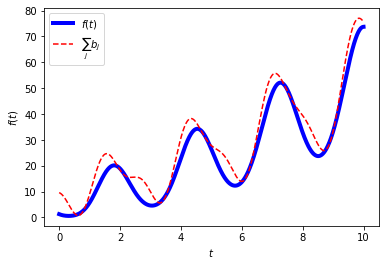

In [108]:
# define the basis vectors
def bp1(t):
    return np.sin(2.3 * t) ** 2

def bp2(t):
    return np.cos(2.3 * t) ** 2

def bp3(t):
    return np.sin(2.3 * t) * np.cos(2.3 * t)

def bp4(t):
    return t * np.sin(2.3 * t)

def bp5(t):
    return t * np.cos(2.3 * t)

def bp6(t):
    return np.sin(2.3 * t)

def bp7(t):
    return np.cos(2.3 * t)

def bp8(t):
    return t ** 2

def bp9(t):
    return t

def bp10(t):
    return np.ones_like(t)

# get array of basis vectors over t
Bpfull = [b(t) for b in [bp1, bp2, bp3, bp4, bp5, bp6, bp7, bp8, bp9, bp10]]
#Bpfull = [b(t) for b in [bp1, bp2, bp4, bp5, bp6, bp7, bp8, bp9, bp10]]

# get indices for 9 tprime values
indicesp = slice(0, -1, int(N/10) + 1)

# get the B matrix
Bp = np.array([row[indicesp] for row in Bpfull])

# evaluate f at tprime values
Fp = f(t[indicesp], A, phi0, m, c) ** 2

# solve for C
Cp = np.dot(Fp, np.linalg.inv(Bp))
#C = np.einsum("i,ij->j", F, np.linalg.inv(B))

# plot original function versus sum of basis vectors
fig, ax = plt.subplots()
ax.plot(t, f(t, A, phi0, m, c) ** 2, "b-", label="$f(t)$", lw=4)
ax.plot(t, np.sum([Cp[i] * Bpfull[i] for i in range(10)], axis=0), "r--", label="$\sum_j b_j$")
ax.legend()
ax.set_xlabel("$t$");
ax.set_ylabel("$f(t)$");

In [101]:
Bp[indicesp]

array([[0.]])

In [8]:
from timeit import timeit

sigma = 2.5  # noise standard deviation

# set some parameters for the function
A = 0.4
phi0 = 2.3
m = -1.5
c = 0.6

# store computation times for both methods
tstandard = []
troq = []

# store log-likelihood values for comparison
logLstandard = []
logLroq = []

# loop over different lengths of data
Ns = [int(n) for n in np.logspace(3, 5, 6)]
for N in Ns:
    t = np.linspace(0, 10, N)
    
    data = f(t, A, phi0, m, c) + np.random.normal(sigma, N)
    
    Bfull = [b(t) for b in [b1, b2, b3, b4]]

    # get indices for 4 tprime values
    indices = slice(0, -1, int(N/4))

    # evaluate the likelihood for some other (random) set of parameters
    Ak = np.random.uniform(-10, 10)
    phi0k = np.random.uniform(0, 2.0 * np.pi)
    mk = np.random.uniform(-10, 10)
    ck = np.random.uniform(-10, 10)

    # sum squared data
    K = np.sum((data / sigma) ** 2)
    
    # use the standard log-likelihood calculation
    def standard():
        datap = data / sigma
        modelp = f(t, Ak, phi0k, mk, ck) / sigma
        logL = -0.5 * (K + np.sum(modelp ** 2) - 2 * np.sum(modelp * datap))
        return logL

    tstandard.append(timeit(standard, number=10000))  # store run time
    logLstandard.append(standard())  # store loglikelihood

    # use ROQ log-likelihood calculation
    D = np.einsum("i,ji->j", data / sigma, Bfull)
    Bj = np.einsum("ji,ji->j", Bfull, Bfull)

    def roq():
        indices = slice(0, -1, int(N/4) + 1)
        datap = data[indices] / sigma

        # get the B matrix
        B = np.array([row[indices] for row in Bfull])
        
        modelp = f(t[indices], Ak, phi0k, mk, ck) / sigma
        C = np.dot(modelp, np.linalg.inv(B))
        logL = -0.5 * (K + np.sum(C**2 * Bj) - 2 * np.sum(C * D))
        return logL
    
    troq.append(timeit(roq, number=10000))
    logLroq.append(roq())

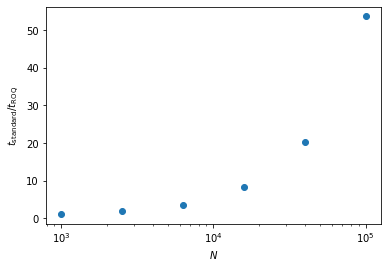

In [9]:
fig, ax = plt.subplots()
ax.semilogx(Ns, np.array(tstandard) / np.array(troq), 'o', ls="none")
ax.set_xlabel("$N$")
ax.set_ylabel(r"$t_{\rm{standard}} / t_{\rm{ROQ}}$");

In [10]:
np.array(logLroq) - np.array(logLstandard)

array([  12796.13582494,    7671.79829019,  287562.12230682,
       -684090.30804443, 1021808.92529297,   94017.109375  ])

In [7]:
logLstandard

[-742103.0561966121,
 -4186376849.467568,
 -7533390642.95529,
 -80452252481.89165,
 -666462117057.3652,
 -2656129589677.112]

In [11]:
datap = data / sigma
modelp = f(t, Ak, phi0k, mk, ck) / sigma
print(np.sum(modelp * datap))

indices = slice(0, -1, int(N/4) + 1)
datap = data[indices] / sigma
B = np.array([row[indices] for row in Bfull])
modelp = f(t[indices], Ak, phi0k, mk, ck) / sigma
C = np.dot(modelp, np.linalg.inv(B))
print(np.sum(C * D))

7688634921.70529
7688634921.705351


In [50]:
print(np.sum(f(t, Ak, phi0k, mk, ck) / sigma ** 2))

#Bfnew = [row / np.sum(row) for row in Bfull]

#Bj = np.einsum("ji->j", np.array(Bfull) ** 2)
Bj = np.einsum("ji,ji->j", Bfull, Bfull)
indices = slice(0, -1, int(N/4) + 1)
B = np.array([row[indices] for row in Bfull])
#B = np.array([row[indices]**2 for row in Bfnew])
modelp = f(t[indices], Ak, phi0k, mk, ck) / sigma
C = np.dot(modelp, np.linalg.inv(B))
print(np.sum(C ** 2 * Bj))

85838.71703158693
893855.3349458172


In [42]:
np.linalg.inv(B)

array([[-1.21698570e+16, -1.21698570e+16,  9.11046184e-02,
         1.21698570e+16],
       [ 1.91060569e+16,  1.91060569e+16, -1.22493528e-01,
        -1.91060569e+16],
       [-8.66283495e+15, -8.66283495e+15, -1.51913791e-17,
         8.66283495e+15],
       [ 1.72663499e+15,  1.72663499e+15,  3.13889100e-02,
        -1.72663499e+15]])

In [43]:
B

array([[5.29009647e-06, 2.56085611e-01, 7.63979211e-01, 9.99344933e-01],
       [9.99994710e-01, 7.43914389e-01, 2.36020789e-01, 6.55066553e-04],
       [1.00002000e-06, 6.25562632e+00, 2.50125017e+01, 5.62706271e+01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [15]:
Bj = np.einsum("ij,ij->j", Bfull, Bfull)

In [19]:
np.sum(np.array(Bfull) ** 2, axis=1)

array([  49019.66313811,   50980.33686189, 3333350.00016667,
        100000.        ])

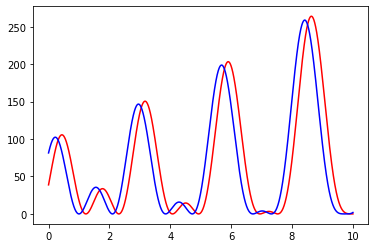

In [51]:
plt.plot(t, f(t, Ak, phi0k, mk, ck) ** 2, "r")
plt.plot(t, f(t, Ak, phi0k + 0.5, mk, ck) ** 2, "b")

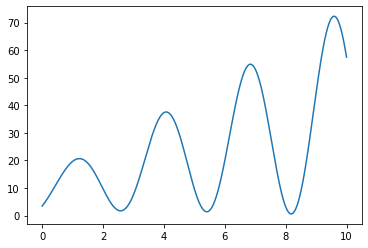

In [67]:
plt.plot(t, 7.5 * t * np.sin(2.3 * t) ** 2 + 1.5 * (t[-1] - t) * np.cos(2 * (2.3 * t)) ** 2)

## Appendix

To calculate the analytical integral for the squared model term in the [example](#A-simple-example)

$$
\int_{t_1}^{t_N} \left(A\sin{(2.3 t + \phi_0)} + mt + c\right)^2 {\rm d}t,
$$


I have used Sympy as below:

In [93]:
import sympy

# set variables
A, t, f, phi0, m, c = sympy.symbols("A t omega phi0 m c")

# define function
func = (A * sympy.sin(f * t + phi0) + m * t + c) ** 2

# calculate definite integral
sympy.simplify(sympy.integrate(func, t)).args[0].args[0]

(12*A*m*sin(omega*t + phi0) - 3*A*omega*(A*sin(omega*t + phi0) + 4*c + 4*m*t)*cos(omega*t + phi0) + omega**2*t*(3*A**2 + 6*c**2 + 6*c*m*t + 2*m**2*t**2))/(6*omega**2)